In [22]:
import skimage
import cv2
from skimage import feature
from skimage import io
import numpy as np
from skimage.transform import hough_line, hough_line_peaks
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.color import rgb2gray
from PIL import Image
from skimage.feature import canny
from skimage import exposure
from skimage.filters import try_all_threshold, sobel
from skimage.filters import gaussian
from skimage.morphology import binary_dilation, binary_erosion
from skimage.transform import rescale, resize, downscale_local_mean, estimate_transform

# from matplotlib.backends.qt_compat import QtWidgets, QtCore, QtGui

from skimage.draw import line
from skimage import data
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.viewer import ImageViewer

(756, 1008)

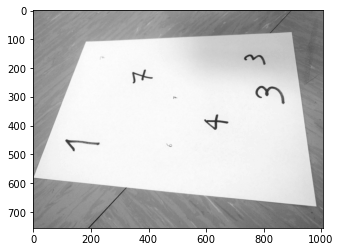

In [2]:
file_path = '/Users/szymon/Documents/Programowanie/compvis-hw/assignment_1/hw_im_1/IMG_20190312_183838.jpg'
image = io.imread(file_path)
image = resize(image, (image.shape[0] // 4, image.shape[1] // 4),
                       anti_aliasing=True)
#convert to color image numpy.ndarray to gray
image_bw = rgb2gray(image)
plt.imshow(image_bw,cmap="gray")
H = image_bw.shape[0]
W = image_bw.shape[1]
H,W

# viewer = ImageViewer(image_bw)
# viewer.show()

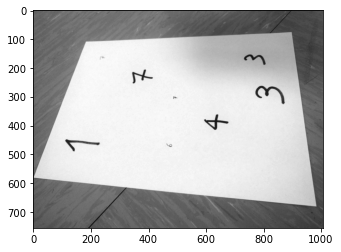

In [3]:
## Enhancing contrast
gamma_corrected = exposure.adjust_gamma(image_bw, 2)
plt.imshow(gamma_corrected,cmap="gray")

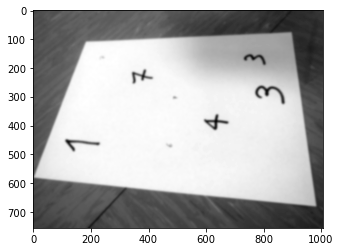

In [4]:
##Blurring image
blurred_image = gaussian(gamma_corrected, multichannel=True, sigma=(3,3))
plt.imshow(blurred_image,cmap="gray")

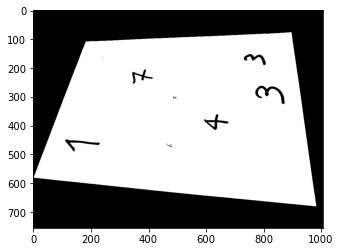

In [5]:
# Import the skimage threshold_otsu package
from skimage.filters import threshold_otsu
# get the global optimal threshold for the leopard image
globalthreshold = threshold_otsu(image=image_bw)
# apply the threshold to the gray image to obtain a binary image
thresholded =image_bw > globalthreshold
# finally show the binary image
plt.imshow(thresholded,cmap="gray")

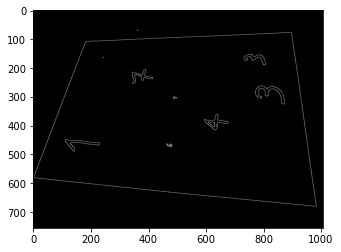

In [6]:
# image_edgedet = feature.canny(blurred_image, sigma=1)
edgedet = canny(thresholded)
imgplot = plt.imshow(edgedet, cmap="gray")

/opt/homebrew/Caskroom/miniforge/base/envs/compvis/lib/python3.9/site-packages/skimage/filters/thresholding.py:409: RuntimeWarning: divide by zero encountered in reciprocal
  crit = np.log(((P1_sq[:-1] * P2_sq[1:]) ** -1) *


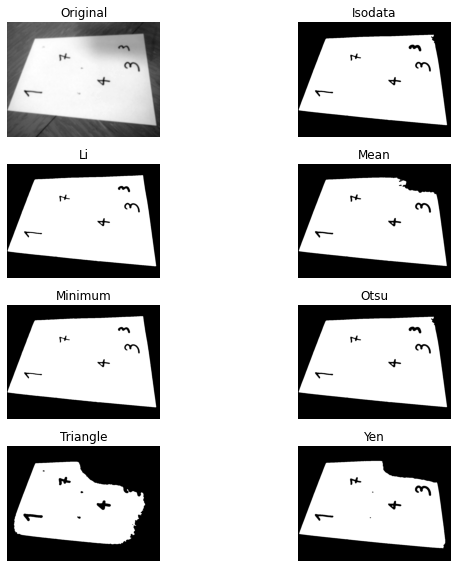

In [7]:
fig, ax = try_all_threshold(blurred_image, figsize=(10, 8), verbose=False)
plt.show()

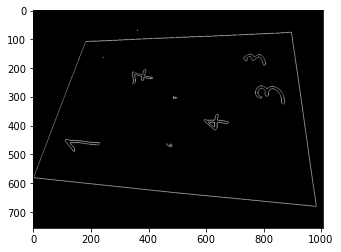

In [8]:
image_edgedet = canny(thresholded, sigma=0)
imgplot = plt.imshow(image_edgedet,cmap="gray")

In [9]:
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(image_edgedet, theta=tested_angles)
print(d)
print(d.shape)

[-1260.         -1258.99960302 -1257.99920603 ...  1257.99920603
  1258.99960302  1260.        ]
(2520,)


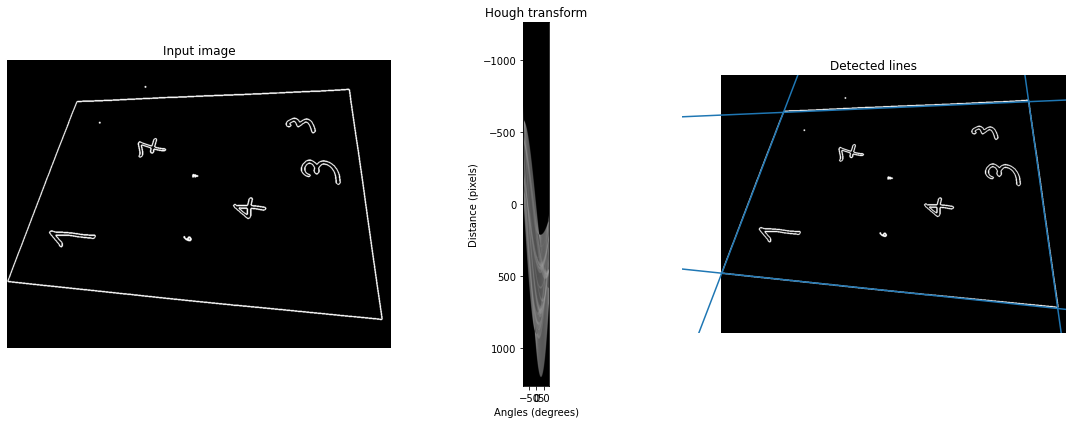

In [10]:
# Constructing test image
image = binary_dilation(image_edgedet)

tested_angles = np.linspace(-np.pi/2, np.pi/2, 360, endpoint=False)
h, theta, d = hough_line(image, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]
ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

line_params = []
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    x0, y0 = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))
    line_params.append((x0,y0,np.tan(angle + np.pi/2)))

plt.tight_layout()
plt.show()

In [11]:
def convert_to_homogenous(line_params):
    homogenous_forms = []
    for param in line_params:
    #convert to directional form of the linear function
    # y = ax + b
        x = param[0]
        y = param[1]
        a = param[2]
        b = y - a*x
    #convert to cannonical form of the linear function
    # Ax + By + C = 0
        A = -a
        B = 1
        C = -b
        homogenous_forms.append([A,B,C])
        
    return homogenous_forms

def find_intersections(homogenous_forms):
    # print(homogenous_forms)
    intersections = set()
    for line_1 in homogenous_forms:
        for line_2 in homogenous_forms:
            #Remove lines that are too close
            print(line_2[0])
            # if abs(line_1[0] - line_2[0]) > 200 and line_1 != line_2:
            #     print(abs(line_1[0] - line_2[0]))
            e = np.cross(line_1,line_2)
            #Equation has no solution, cannot divide by zero
            if e[2] == 0:
                continue
            else:
                x = e[0]/e[2]
                y = e[1]/e[2]
                # Intersection points are part of the image
                if (0<= x<= W) and (0 <= y <= H):
                    intersections.add((x,y))

    intersections = list(intersections)
    return intersections




In [12]:
print(line_params)

[(-60.28458152678903, 573.5694796161652, 0.10510423526567639), (5.127312663309252, 117.43476713393744, -0.043660942908512135), (871.2865150753046, -122.45133409362103, 7.115369722384208), (195.6627432969167, 75.1078901480532, -2.6050890646938014)]


In [13]:
homogenous_forms = convert_to_homogenous(line_params)
intersections = find_intersections(homogenous_forms)

-0.10510423526567639
0.043660942908512135
-7.115369722384208
2.6050890646938014
-0.10510423526567639
0.043660942908512135
-7.115369722384208
2.6050890646938014
-0.10510423526567639
0.043660942908512135
-7.115369722384208
2.6050890646938014
-0.10510423526567639
0.043660942908512135
-7.115369722384208
2.6050890646938014


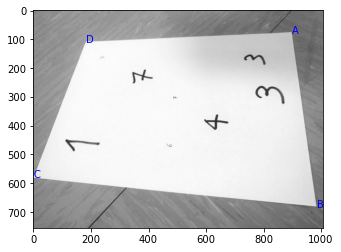

In [14]:
alphabet = ['A','B','C','D']
for c in intersections:
    # plt.plot(c[0], c[1],'ob',color="green")
    plt.text(c[0], c[1],f'{alphabet.pop(0)}', color='blue')
plt.imshow(image_bw, cmap=cm.gray)
plt.show()

In [15]:
#A4 paper card = 210 x 297 mm
# 3 pixels per mm
w,h = 630, 891

A = np.array([w,h])
B = np.array([0,h])
C = np.array([0,0])
D = np.array([w,0])

In [16]:
a = intersections[0]
b = intersections[1]
c = intersections[2]
d = intersections[3]

a = np.array([a[0],a[1]])
b = np.array([b[0],b[1]])
c = np.array([c[0],c[1]])
d = np.array([d[0],d[1]])

invtf = estimate_transform("projective",src=np.vstack((A,B,C,D)),
dst=np.vstack((a,b,c,d)))

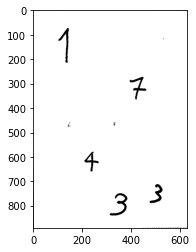

In [23]:
tim = skimage.transform.warp(image=thresholded,inverse_map=invtf,output_shape=(h,w))
plt.imshow(tim,cmap='gray')

In [33]:
import cv2
import numpy as np

img = Image.fromarray(tim.astype(np.uint8))
# read image
# threshold
thresh = cv2.threshold(img,128,255,cv2.THRESH_BINARY)[1]

# get contours
result = img.copy()
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
    cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 2)
    print("x,y,w,h:",x,y,w,h)
 
# save resulting image
cv2.imwrite('two_blobs_result.jpg',result)      

# show thresh and result    
cv2.imshow("bounding_box", result)
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'
